# Forecasting fire probability with SMLFire1.0

Author: Jatan Buch (v1, 230724) || (v2, 230818) || (v3, 230824) || (v4, 230831) || (v5, 231101) || (v6, 240701)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
from copy import deepcopy

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *
from ssf_utils import *

#modules for data processing and gradient boosting 
from ngboost import NGBRegressor, distns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error, r2_score
import pickle # for saving and loading models
from pathlib import Path
import shap

#modules for neural network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Fire probability map

### Generate fire probability maps

In [ ]:
# load in data frame with observed climate, vegetation, and human predictors

target_yr= 2024
rescale_flag= True
if target_yr < 2023:
    clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2022_rescaled_data.h5')
    sys_no= None
else:
    clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w%s_rescaled_data.h5'%target_yr)
    climdf= deepcopy(clim_df)
    sys_no= 51
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64)

# also load in wildfire_df

wildfire_df= pd.read_hdf('../data/firelist/wildfire_df_wumi2_modis_2023.h5', key= 'df')
wildfire_df['fire_month']= (wildfire_df['final_year']*12 + wildfire_df['final_month']) - (1984*12 + 1) # no. of months since 1984-01

pred_var_arr= ['Tmax', 'Prec', 'VPD', 'Tmin'] #'VPD', 'FFWI',
if target_yr == 'baseline':
    pred_mon_arr= baseline_mon_arr_func(start_yr= 2001, end_yr= 2019, mindx= [5, 6, 7, 8, 9]).values # np.sort(np.append(np.append(np.arange(209, 426, 12), np.arange(210, 427, 12)), np.arange(211, 428, 12))) #2001-2020 
else:
    pred_mon_arr=  np.array([460, 461, 462, 463, 464]) - (2022 - target_yr)*12  #464
firemon_pred_flag= 'dynamical_forecasts' #'dynamical_forecasts' #'observations'
ens_no= 11
pred_drop_cols= ['SWE_mean', 'SWE_max', 'AvgSWE_3mo']

X_pred_ur_df, X_pred_test_df= fire_pred_df_func(clim_df, target_yr, pred_mon_arr, pred_var_arr, firemon_pred_flag, sys_no= sys_no, ens_no= ens_no, freq_flag= 'prediction') #freq_flag= 'ensemble' or 'prediction'

In [ ]:
freq_id= '08_07_23'
seed= 654

## Function to generate a spatial map of fire probability forecasts from a saved MDN model and save the resultant xarray for post-processing

fire_prob_pred_func(freq_id= freq_id, seed= seed, X_tot_df= X_pred_ur_df, X_test_df= X_pred_test_df, pred_mon_arr= pred_mon_arr, sav_flag= True, target_year= target_yr, \
                                                                                                                            firemon_pred_flag= firemon_pred_flag, ens_no= (ens_no))
        

### Months with most fires

In [9]:
smon= 5
baseline_arr= baseline_mon_arr_func(start_yr= 2001, end_yr= 2019, mindx= smon).values
n_fires_baseline_arr= np.round([len(wildfire_df[wildfire_df['fire_month'].isin(baseline_arr + (fmon - smon))])/20 for fmon in [5, 6, 7, 8, 9]])

In [10]:
n_fires_baseline_arr

array([ 31.,  94., 170., 156.,  52.])

### Dynamical climate ensemble forecasts

In [2]:
plot_yr= 2024
firemon_pred_flag= 'dynamical_forecasts'
freq_id= '08_07_23' 
seed= 654
lead_mo_may= 1

wildfire_df= pd.read_hdf('../data/firelist/wildfire_df_wumi2_modis_2023.h5', key= 'df')
wildfire_df['fire_month']= (wildfire_df['final_year']*12 + wildfire_df['final_month']) - (1984*12 + 1) # no. of months since 1984-01

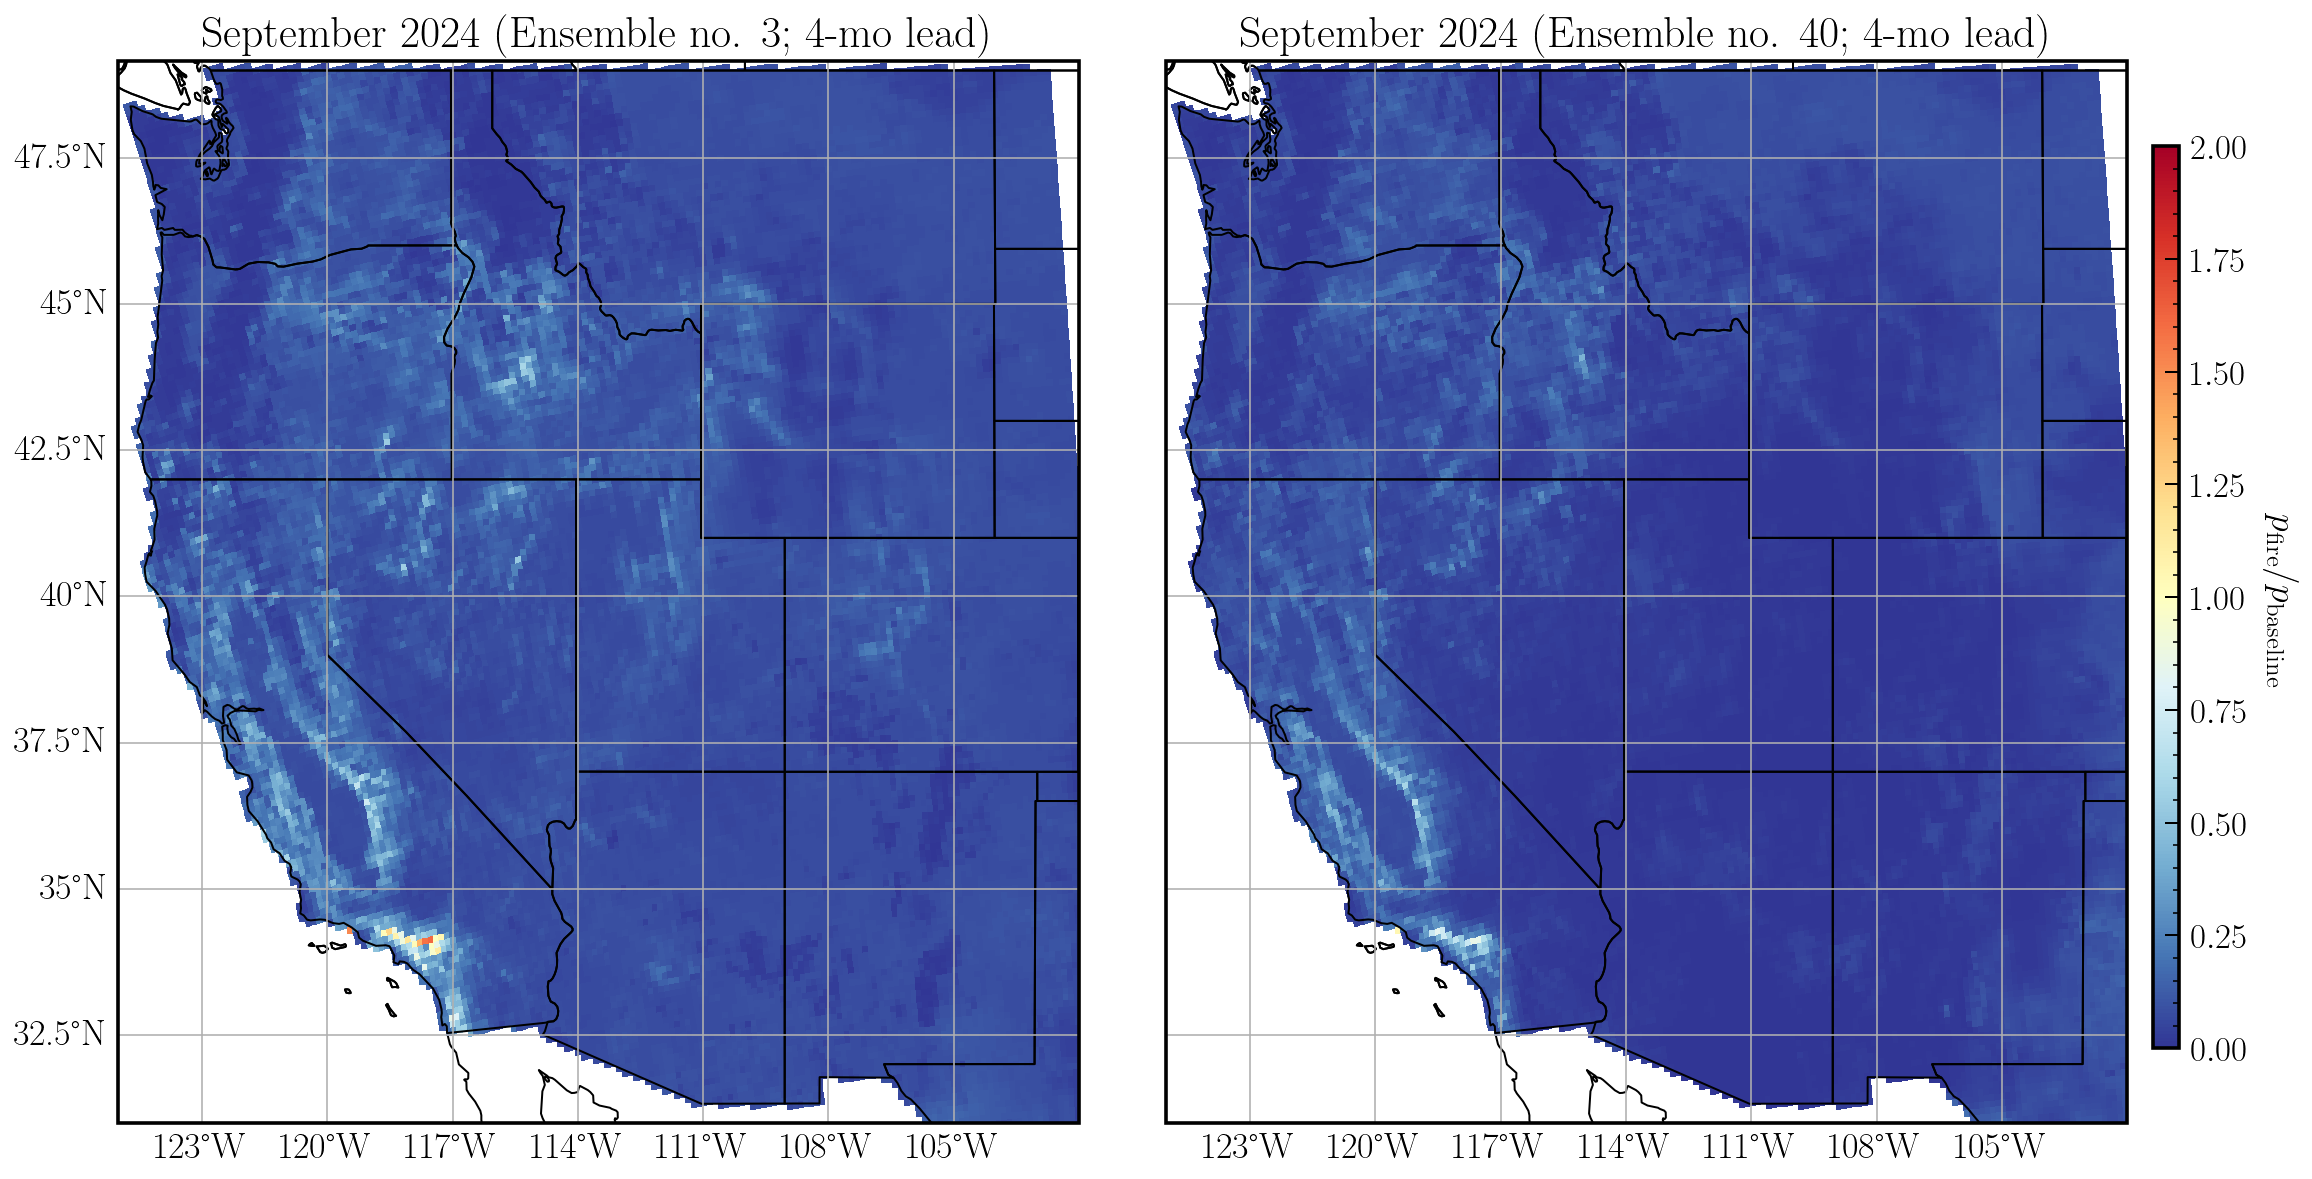

In [36]:
pred_mon_1= 9
lead_mon_1= pred_mon_1 - 6
ens_no_1= 3
ens_no_2= 40
#pred_prob_xarr_jun= ens_mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, smon= 5, fmon= pred_mon_1, fire_df= wildfire_df, firemon_pred_flag= firemon_pred_flag)
pred_prob_xarr_sep= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, smon= 5, fmon= pred_mon_1, fire_df= wildfire_df, firemon_pred_flag= firemon_pred_flag, ens_no= ens_no_1)
pred_prob_xarr_sep2= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, smon= 5, fmon= pred_mon_1, fire_df= wildfire_df, firemon_pred_flag= firemon_pred_flag, ens_no= ens_no_2)
#pred_prob_xarr_std= ens_mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, smon= 5, fmon= pred_mon_1, fire_df= wildfire_df, firemon_pred_flag= firemon_pred_flag, statistic= 'std')
lat_long_fire_grid= coord_transform(pred_prob_xarr_sep['X'][:].data, pred_prob_xarr_sep['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

#ens_prob_xarr.std(dim= 'ens_no')[0:2].mean(dim= 'month') #
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 4)
norm = colors.TwoSlopeNorm(vmin= 0, vcenter= 1, vmax= 2)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_sep, norm= norm, cmap=plt.cm.RdYlBu_r) #vmin= 0, vcenter= 1, vmax= 2,
if plot_yr != 2024:
    ax.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 5]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 5]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
# cax= fig.add_axes([ax.get_position().x1 - 0.01, ax.get_position().y1 - 0.58, 0.01, ax.get_position().height + 0.1])
# cbar= fig.colorbar(CS, cax= cax, orientation= 'vertical')
# cbar.set_label(r'$p_{\rm fire}/p_{\rm baseline}$', labelpad= 25, rotation= 270, fontsize= 18)
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)

ax2= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_sep2, norm= norm, cmap=plt.cm.RdYlBu_r) #vmin= 0, vcenter= 1, vmax= 2,
cax2= fig.add_axes([ax2.get_position().x1 + 0.01, ax2.get_position().y1 - 0.58, 0.01, ax2.get_position().height + 0.1])
cbar= fig.colorbar(CS2, cax= cax2, orientation= 'vertical')
cbar.set_label(r'$p_{\rm fire}/p_{\rm baseline}$', labelpad= 25, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)

# ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
# ax1.set_extent(extent);
# ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
# ax1.add_feature(cfeature.STATES, edgecolor='black');
# CS1= ax1.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_jul, norm= norm, cmap=plt.cm.RdYlBu_r)
# if plot_yr != 2024:
#     ax1.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 6]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 6]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
# cax= fig.add_axes([ax1.get_position().x0 - 0.12, ax1.get_position().y0 - 0.14, ax1.get_position().width + 0.05, 0.02])
# cbar= fig.colorbar(CS1, cax= cax, orientation= 'horizontal')
# cbar.set_label(r'$p_{\rm fire}/p_{\rm baseline}$', labelpad= 5, rotation= 0, fontsize= 18)
# gl1= ax1.gridlines(draw_labels=True);
# gl1.xlabel_style = {'size': 18, 'color': 'black'}
# gl1.ylabel_style = {'size': 18, 'color': 'black'}
# gl1.top_labels = False
# gl1.left_labels = False
# gl1.right_labels = False
# ax1.set_aspect(1.4/1)

# fig.subplots_adjust(wspace= 0.6)
# ax2= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
# ax2.set_extent(extent);
# ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
# ax2.add_feature(cfeature.STATES, edgecolor='black');
# CS2= ax2.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_std, vmin= 0, vmax= 1.0, cmap=plt.cm.BuGn) #vmin= 0, vmax= 2.5, plt.cm.BuGn
# #if plot_yr != 2024:
# #    ax2.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 7]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +7]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
# cax1= fig.add_axes([ax2.get_position().x1 + 0.01, ax2.get_position().y1 - 0.56, 0.01, ax2.get_position().height + 0.14])
# cbar1= fig.colorbar(CS2, cax= cax1, orientation= 'vertical')
# cbar1.set_label(r'$\sigma_{p_{\rm fire}}/p_{\rm baseline}$', labelpad= 25, rotation= 270, fontsize= 18) #$\sigma_{p_{\rm fire}}/p_{\rm baseline}$'
# gl2= ax2.gridlines(draw_labels=True);
# gl2.xlabel_style = {'size': 18, 'color': 'black'}
# gl2.ylabel_style = {'size': 18, 'color': 'black'}
# gl2.top_labels = False
# gl2.left_labels = False
# gl2.right_labels = False
# ax2.set_aspect(1.4/1)
if firemon_pred_flag == 'observations':
    ax.set_title(r'June %d'%plot_yr, fontsize= 22);
    #ax1.set_title(r'July %d'%plot_yr, fontsize= 22);
    ax2.set_title(r'August %d'%plot_yr, fontsize= 22);
    # plt.savefig('../plots/smlfire_output/pred_fire_prob_%s'%freq_id + '_%d_'%seed + 'obs_%d.png'%plot_yr, bbox_inches='tight', dpi= 200);
else:
    ax.set_title(r'September %d'%plot_yr + ' (Ensemble no. %d; '%ens_no_1 + '%d-mo lead)'%(lead_mo_may + lead_mon_1), fontsize= 22);
    ax2.set_title(r'September %d'%plot_yr + ' (Ensemble no. %d; '%ens_no_2 + '%d-mo lead)'%(lead_mo_may + lead_mon_1), fontsize= 22);
    #ax1.set_title(r'July %d'%plot_yr + ' (%d-mo lead)'%(lead_mo_may + lead_mon_1 + 1), fontsize= 22);
    #ax2.set_title(r'August %d'%plot_yr + ' (Ensemble mean; ' + '%d-mo lead)'%(lead_mo_may+3), fontsize= 22);
    #ax2.set_title(r'September %d (Ensemble uncertainty)'%plot_yr, fontsize= 22);
    plt.savefig('../plots/smlfire_output/' + '%s/'%firemon_pred_flag + '%s/'%plot_yr + 'pred_fire_prob_%s'%freq_id + '_%d'%seed + '_ens_mean_sep_minmax_ens_%d.png'%plot_yr, bbox_inches='tight', dpi= 200);

In [20]:
plot_yr= 2022
mdn_tot_df= pd.DataFrame([])
for ens_no in range(51):
    mdn_tmp_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/dynamical_forecasts/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%plot_yr)
    mdn_tot_df= pd.concat([mdn_tot_df, mdn_tmp_df], axis= 0)
mdn_freq_test_tot_df= mdn_tot_df.groupby(mdn_tot_df.index).mean().round().astype(int)

ens_prob_xarr= xarray.concat([xarray.open_dataarray('../sav_files/ssf_pred_files/dynamical_forecasts/pred_prob_xarr_%s'%freq_id + '_%d_'%seed + \
                                                                                                    'df_%d'%ens_no + '_%s.nc'%plot_yr) for ens_no in range(51)], dim= 'ens_no')

In [21]:
mdn_freq_test_tot_df.groupby('month')['pred_mean_freq'].sum()

month
460    32
461    34
462    52
463    45
464    54
Name: pred_mean_freq, dtype: int64

### Statistical climate ensemble forecasts

In [17]:
# Function to generate a spatial map of fire probability forecasts from a saved MDN model and save the resultant xarray for post-processing
fire_prob_pred_func(freq_id= '08_07_23', seed= 654, X_tot_df= X_pred_ur_df, X_test_df= X_pred_test_df, pred_mon_arr= pred_mon_arr, sav_flag= True, target_year= target_yr, \
                                                                                                                           firemon_pred_flag= 'statistical_forecasts', ens_no= ens_no)
#fire_prob_pred_func(freq_id= '08_07_23', seed= 654, X_tot_df= X_pred_ur_df, X_test_df= X_pred_test_df, pred_mon_arr= pred_mon_arr, sav_flag= True, target_year= target_yr, \
#                                                                                                                            firemon_pred_flag= 'observations')

747/747 [==============================] - 0s 404us/step
Saved fire probability xarray for 2023


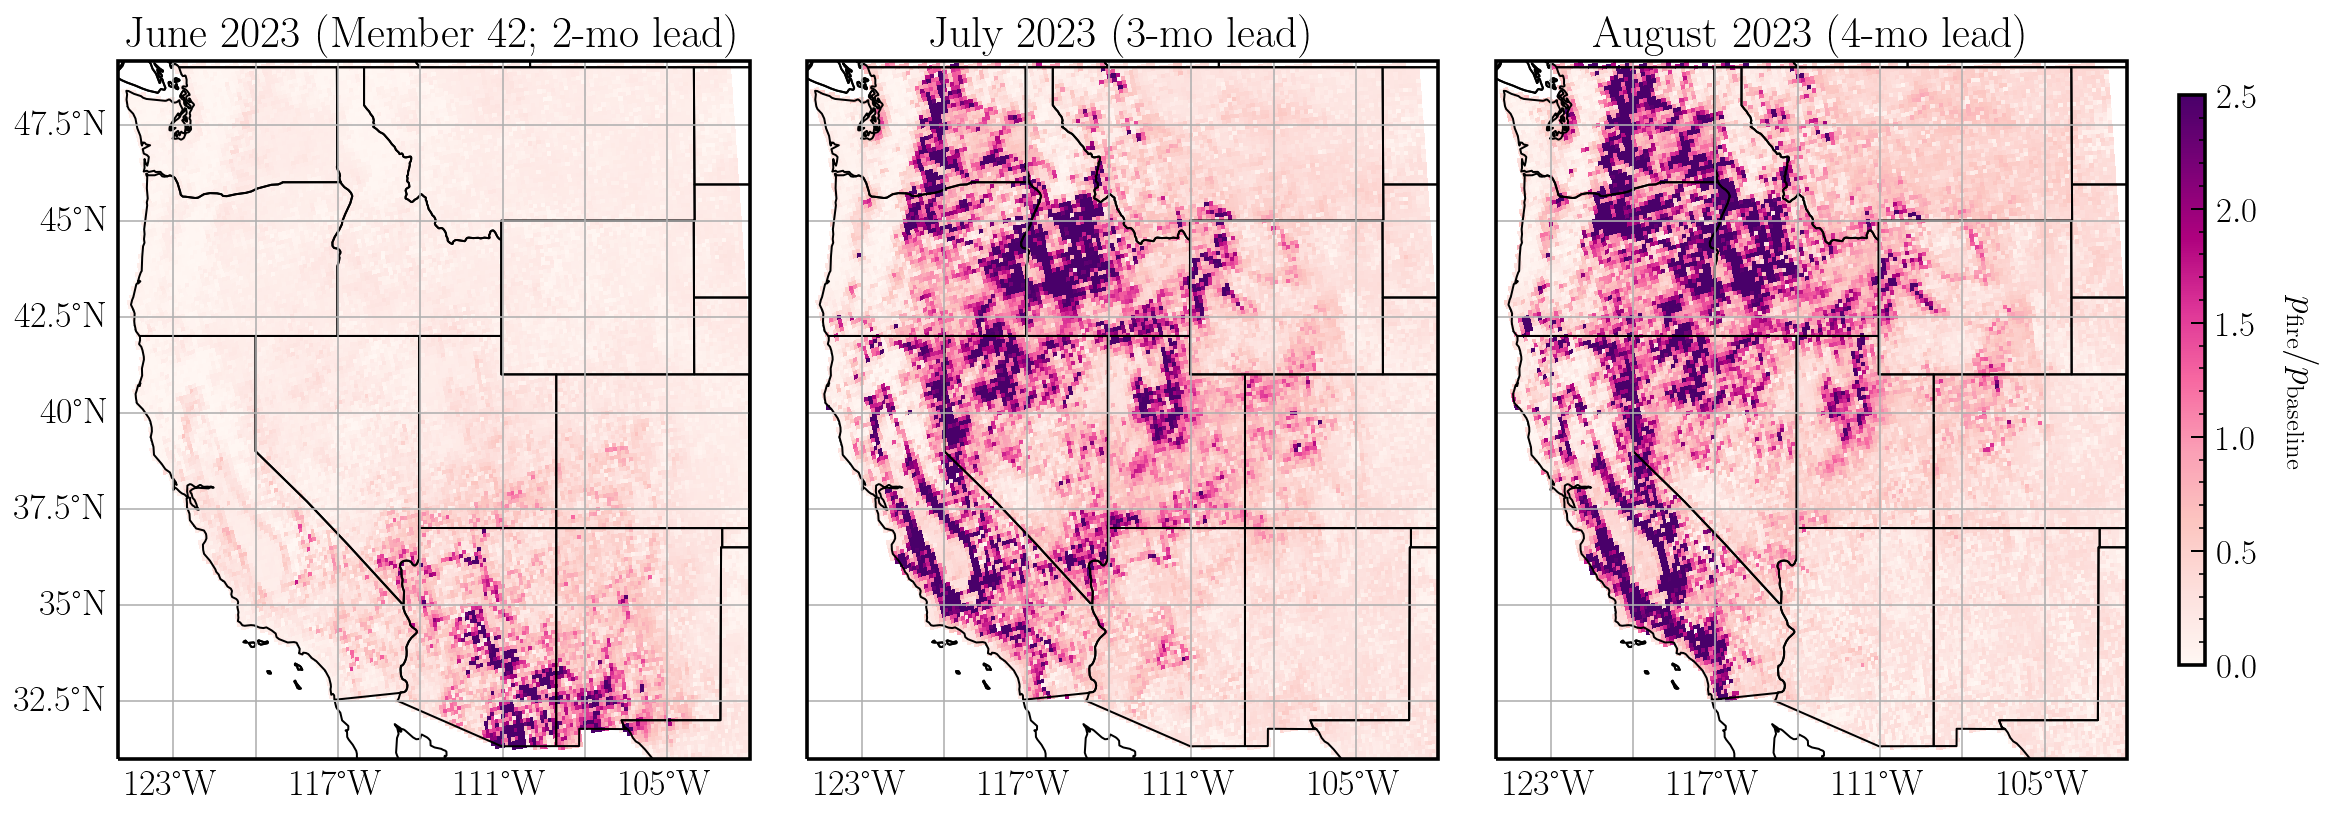

In [19]:
plot_yr= 2023
lead_mo_may= 1
pred_prob_xarr_jun= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, fmon= 5, fire_df= wildfire_df, firemon_pred_flag= 'statistical_forecasts', \
                                                                                                                            ens_no= ens_no, pred_fire_df= mdn_freq_test_df)
pred_prob_xarr_jul= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, fmon= 6, fire_df= wildfire_df, firemon_pred_flag= 'statistical_forecasts', \
                                                                                                                            ens_no= ens_no, pred_fire_df= mdn_freq_test_df)
pred_prob_xarr_aug= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, fmon= 7, fire_df= wildfire_df, firemon_pred_flag= 'statistical_forecasts', \
                                                                                                                            ens_no= ens_no, pred_fire_df= mdn_freq_test_df)
lat_long_fire_grid= coord_transform(pred_prob_xarr_jun['X'][:].data, pred_prob_xarr_jun['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_jun, vmin= 0, vmax= 2.5, cmap=plt.cm.RdPu)
if plot_yr != 2023:
    ax.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +5]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 5]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
#cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_jul, vmin= 0, vmax= 2.5, cmap=plt.cm.RdPu)
if plot_yr != 2023:
    ax1.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +6]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +6]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_aug, vmin= 0, vmax= 2.5, cmap=plt.cm.RdPu)
if plot_yr != 2023:
    ax2.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 7]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +7]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
cax= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.05])
cbar= fig.colorbar(CS2, cax= cax, orientation= 'vertical')
cbar.set_label(r'$p_{\rm fire}/p_{\rm baseline}$', labelpad= 30, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
if firemon_pred_flag == 'observations':
    ax.set_title(r'June %d'%plot_yr, fontsize= 22);
    ax1.set_title(r'July %d'%plot_yr, fontsize= 22);
    ax2.set_title(r'August %d'%plot_yr, fontsize= 22);
    # plt.savefig('../plots/smlfire_output/pred_fire_prob_%s'%freq_id + '_%d_'%seed + 'obs_%d.png'%plot_yr, bbox_inches='tight', dpi= 200);
else:
    ax.set_title(r'June %d'%plot_yr + ' (Member %d'%ens_no + '; %d-mo lead)'%(lead_mo_may+1) + '', fontsize= 22);
    ax1.set_title(r'July %d'%plot_yr + ' (%d-mo lead)'%(lead_mo_may+2) + '', fontsize= 22);
    ax2.set_title(r'August %d'%plot_yr + ' (%d-mo lead)'%(lead_mo_may+3) + '', fontsize= 22);
    #plt.savefig('../plots/smlfire_output/' + '%s'%firemon_pred_flag + '/pred_fire_prob_%s'%freq_id + '_%d_'%seed + '%d'%ens_no + '_%d.png'%plot_yr, bbox_inches='tight', dpi= 200);

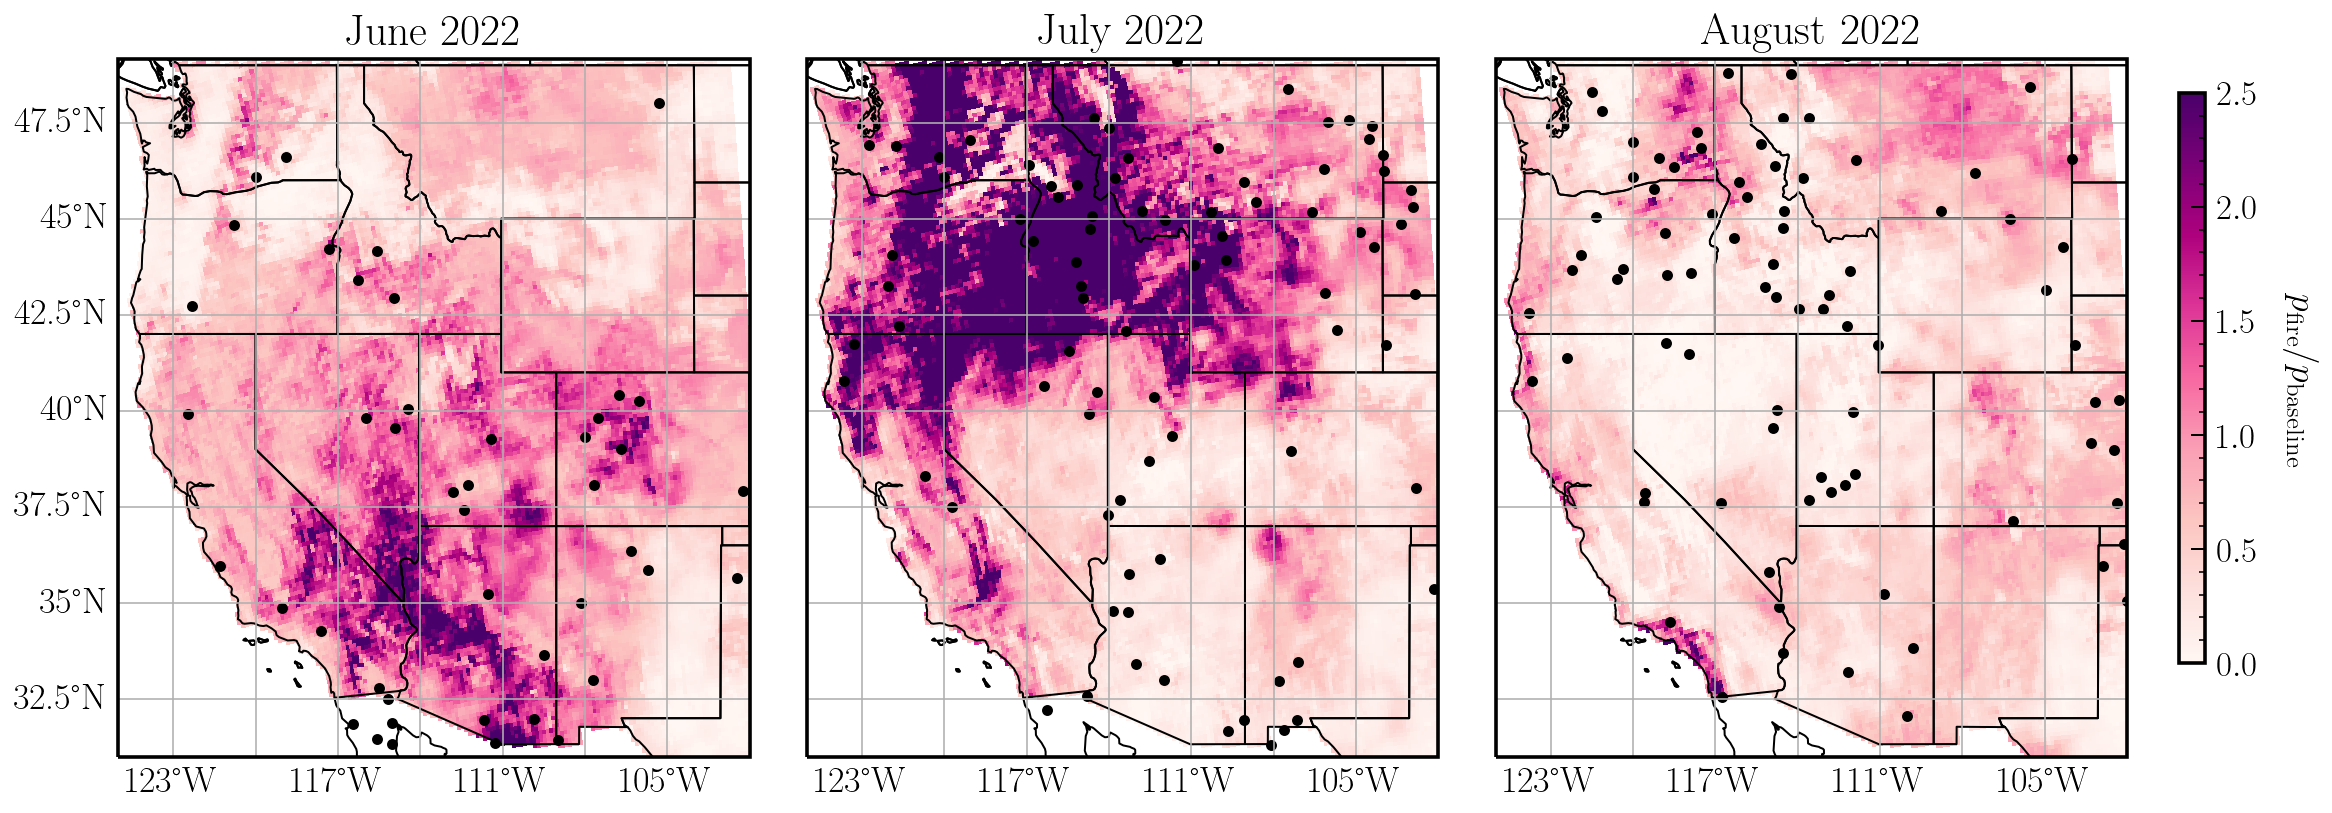

In [10]:
plot_yr= 2023
lead_mo_may= 1
pred_prob_xarr_jun= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, fmon= 5, fire_df= wildfire_df, firemon_pred_flag= 'observations')
pred_prob_xarr_jul= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, fmon= 6, fire_df= wildfire_df, firemon_pred_flag= 'observations')
pred_prob_xarr_aug= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, fmon= 7, fire_df= wildfire_df, firemon_pred_flag= 'observations')
lat_long_fire_grid= coord_transform(pred_prob_xarr_jun['X'][:].data, pred_prob_xarr_jun['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_jun, vmin= 0, vmax= 2.5, cmap=plt.cm.RdPu)
if plot_yr != 2023:
    ax.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +5]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 5]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
#cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_jul, vmin= 0, vmax= 2.5, cmap=plt.cm.RdPu)
if plot_yr != 2023:
    ax1.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +6]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +6]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_aug, vmin= 0, vmax= 2.5, cmap=plt.cm.RdPu)
if plot_yr != 2023:
    ax2.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 7]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +7]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
cax= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.05])
cbar= fig.colorbar(CS2, cax= cax, orientation= 'vertical')
cbar.set_label(r'$p_{\rm fire}/p_{\rm baseline}$', labelpad= 30, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
if firemon_pred_flag == 'observations':
    ax.set_title(r'June %d'%plot_yr, fontsize= 22);
    ax1.set_title(r'July %d'%plot_yr, fontsize= 22);
    ax2.set_title(r'August %d'%plot_yr, fontsize= 22);
    # plt.savefig('../plots/smlfire_output/pred_fire_prob_%s'%freq_id + '_%d_'%seed + 'obs_%d.png'%plot_yr, bbox_inches='tight', dpi= 200);
else:
    ax.set_title(r'June %d'%plot_yr + ' (Member %d'%ens_no + '; %d-mo lead)'%(lead_mo_may+1) + '', fontsize= 22);
    ax1.set_title(r'July %d'%plot_yr + ' (%d-mo lead)'%(lead_mo_may+2) + '', fontsize= 22);
    ax2.set_title(r'August %d'%plot_yr + ' (%d-mo lead)'%(lead_mo_may+3) + '', fontsize= 22);
    # plt.savefig('../plots/smlfire_output/' + '%s'%firemon_pred_flag + '/pred_fire_prob_%s'%freq_id + '_%d_'%seed + '%d'%ens_no + '_%d.png'%plot_yr, bbox_inches='tight', dpi= 200);

## Skill score

In [ ]:
firemon_pred_flag= 'dynamical_forecasts' # 'statistical_forecasts'
freq_id= '08_07_23' 
seed= 654

tmax_xr= xr.open_dataarray('../data/12km/climate/primary/tmax.nc')
maskXY= ~tmax_xr[0].isnull().drop('time')
sav_flag= False

### Data pre-processing

In [ ]:
# concatenate all the predicted probability xarrays into one xarray along a new dimension ens_no

yr_arr= np.arange(2000, 2020, 1, dtype= np.int64)
for yr in tqdm(yr_arr):
    n_ens= 25
    ens_no_arr= np.arange(0, n_ens, 1, dtype= np.int64)
    pred_prob_xarr= xarray.open_dataarray('../sav_files/ssf_pred_files/%s/'%firemon_pred_flag +  '%s/'%yr \
                                                                        + 'pred_prob_xarr_%s'%freq_id + '_%d_'%seed + 'df_%d'%ens_no_arr[0] + '_%s.nc'%yr)
    for ens_no in ens_no_arr[1:]:
        pred_prob_xarr= xarray.concat([pred_prob_xarr, xarray.open_dataarray('../sav_files/ssf_pred_files/%s/'%firemon_pred_flag +  '%s/'%yr \
                                                                        + 'pred_prob_xarr_%s'%freq_id + '_%d_'%seed + 'df_%d'%ens_no + '_%s.nc'%yr)], dim= 'ens_no')
    pred_prob_xarr= pred_prob_xarr.assign_coords(ens_no= ens_no_arr[:ens_no+1])
    #pred_prob_xarr.to_netcdf('../sav_files/ssf_pred_files/%s/'%firemon_pred_flag + 'pred_prob_xarr_%s'%freq_id + '_%d'%seed + '_%s.nc'%yr)
    sig_pred_xarr= 1/(1 + np.exp(-pred_prob_xarr))
    prob_xarr_corr= np.log10(sig_pred_xarr/(sig_pred_xarr.min()))/(1E-7)
    if sav_flag:
        prob_xarr_corr.to_netcdf('../sav_files/ssf_pred_files/%s/'%firemon_pred_flag + 'fire_prob_xarr_%s'%freq_id + '_%d'%seed + '_%s.nc'%yr)

100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


In [ ]:
prob_xarr= xarray.open_dataarray('../sav_files/ssf_pred_files/%s/'%firemon_pred_flag + 'fire_prob_xarr_%s'%freq_id + '_%d'%seed + '_%s.nc'%yr_arr[0])
for yr in yr_arr[1:]:
    prob_xarr= xarray.concat([prob_xarr, xarray.open_dataarray('../sav_files/ssf_pred_files/%s/'%firemon_pred_flag + 'fire_prob_xarr_%s'%freq_id + '_%d'%seed + '_%s.nc'%yr)], dim= 'month')
prob_bin_xarr= prob_xarr.where(prob_xarr <= 0.5, 1)
prob_bin_xarr= prob_bin_xarr.where(maskXY)
prob_bin_xarr= prob_bin_xarr.rename({'month': 'time'})
if sav_flag:
    prob_xarr.to_netcdf('../sav_files/ssf_pred_files/%s/'%firemon_pred_flag + 'fire_prob_xarr_%s'%freq_id + '_%d'%seed + '_2000-2019.nc')
    prob_bin_xarr.to_netcdf('../sav_files/ssf_pred_files/%s/'%firemon_pred_flag + 'bs_fire_prob_xarr_%s'%freq_id + '_%d'%seed + '_2000-2019.nc')

In [ ]:
baseline_xarr= xarray.open_dataarray('../sav_files/ssf_pred_files/pred_prob_xarr_%s'%freq_id + '_%d'%seed + '_obs_baseline.nc')
sig_baseline_xarr= 1/(1 + np.exp(-baseline_xarr))
prob_baseline_xarr= np.log10(sig_baseline_xarr/(sig_baseline_xarr.min()))/(1E-7) #kludge no. 1

prob_bin_baseline_xarr= prob_baseline_xarr.where(prob_baseline_xarr <= 0.5, 1)
prob_bin_baseline_xarr= prob_bin_baseline_xarr.where(maskXY)
prob_bin_baseline_xarr= prob_bin_baseline_xarr.rename({'month': 'time'})
if sav_flag:
    prob_bin_baseline_xarr.to_netcdf('../sav_files/ssf_pred_files/bs_fire_prob_xarr_%s'%freq_id + '_%d'%seed + '_obs_baseline.nc')

In [ ]:
burndata= xarray.open_dataarray('../data/12km/wildfire/burnarea_12km.nc')
burndata= burndata.sel(time= (burndata.time.dt.year >= 2000) & (burndata.time.dt.year < 2020)) 
fcounts_data= burndata.where(burndata == 0, 1)
fcounts_data= fcounts_data.where(maskXY)
fcounts_data= fcounts_data.sel(time= fcounts_data.time[(fcounts_data.time.dt.year*12 + fcounts_data.time.dt.month - 1984*12 - 1).isin(prob_xarr.time)])
fcounts_data['time'] = fcounts_data.time.dt.year*12 + fcounts_data.time.dt.month - 1984*12 - 1
if sav_flag:
    fcounts_data.to_netcdf('../data/12km/wildfire/fcounts_data.nc')

### Brier skill score

In [ ]:
prob_xarr= xarray.open_dataarray('../sav_files/ssf_pred_files/%s/'%firemon_pred_flag + 'bs_fire_prob_xarr_%s'%freq_id + '_%d'%seed + '_2000-2019.nc')
fcounts_data= xarray.open_dataarray('../data/12km/wildfire/fcounts_data.nc')
prob_baseline_xarr= xarray.open_dataarray('../sav_files/ssf_pred_files/bs_fire_prob_xarr_%s'%freq_id + '_%d'%seed + '_obs_baseline.nc')

bs_xarr= xs.brier_score(fcounts_data, prob_xarr, dim= 'ens_no')
bs_baseline_xarr= xs.brier_score(fcounts_data[5:], prob_baseline_xarr, dim= 'time')
corr_fac= 1 + 1/len(prob_xarr.ens_no)
bss_xarr= 1 - corr_fac*(bs_xarr/bs_baseline_xarr)

wildfire_df= pd.read_csv(data_dir + resp_input_path + "west_US_fires_1984-2020_WUMI2.txt", 
                         usecols= (1, 2, 18, 19, 20, 21, 22, 23, 24, 25), delimiter= ',')
loncoord, latcoord= coord_transform(bs_xarr['X'][:].data, bs_xarr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

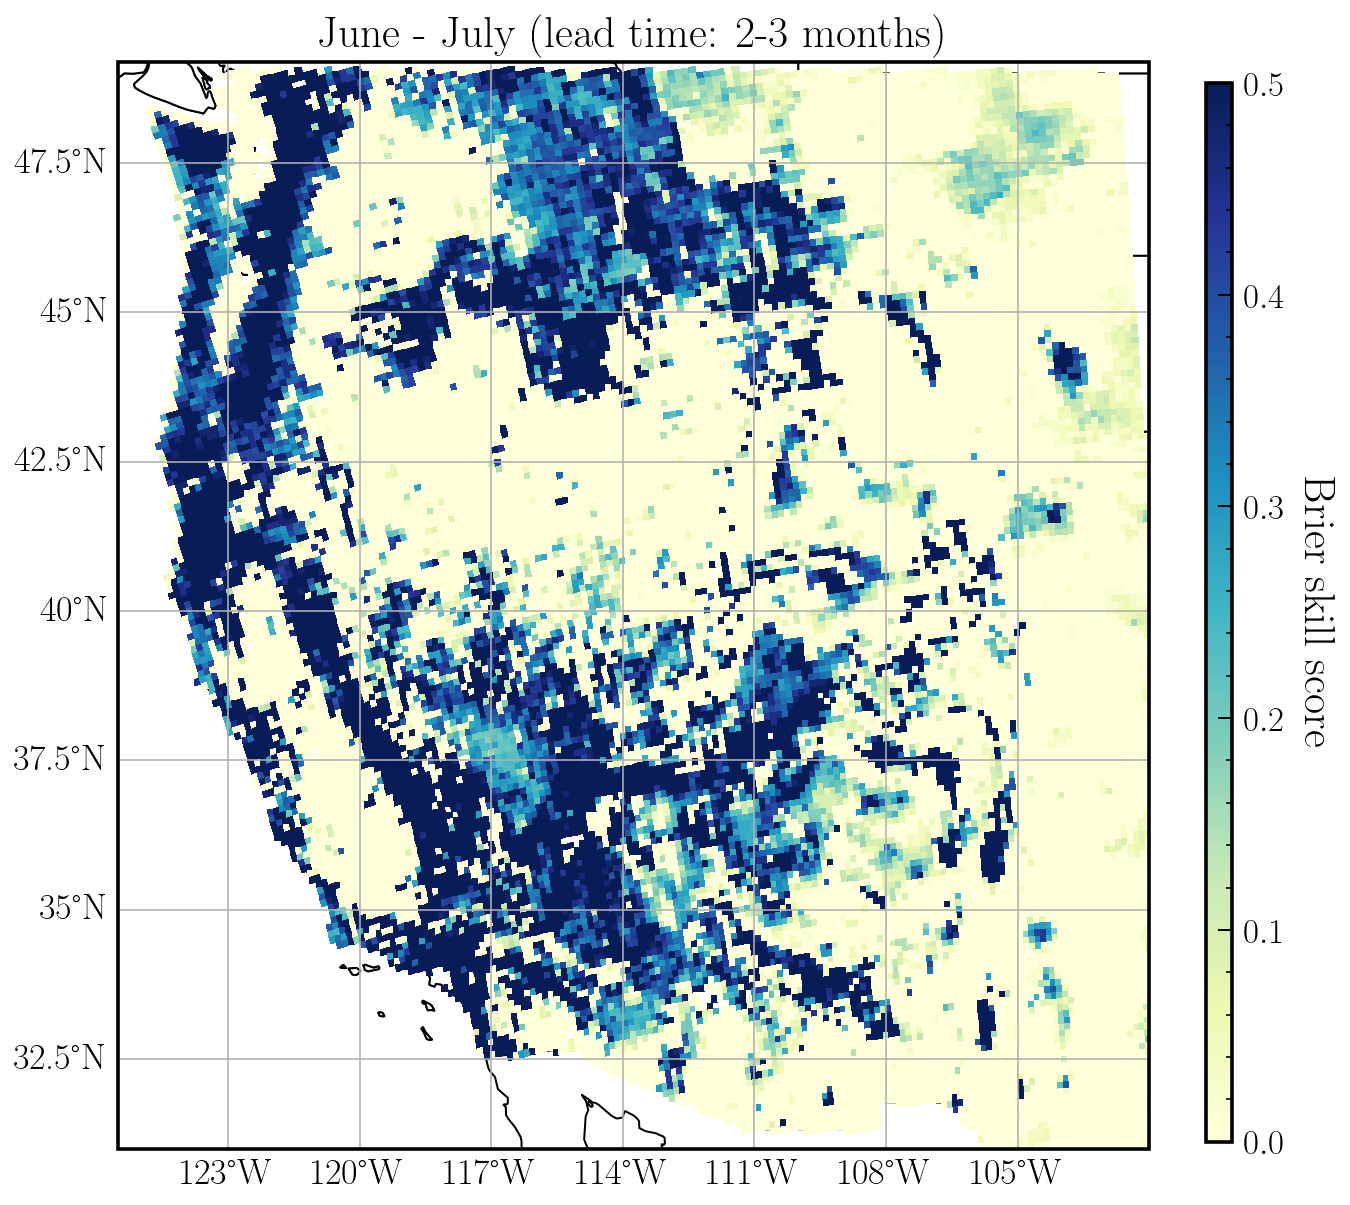

In [ ]:
extent = [-125.5, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor= 'white', zorder= 1);

#ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= 'black', s= 10, transform=ccrs.PlateCarree(), zorder= 10)
jun_jul_bss= bss_xarr.where(bss_xarr > 0, 0).where(maskXY)[1:3].mean(dim= 'time')/bs_baseline_xarr
CS= ax.pcolormesh(loncoord, latcoord, jun_jul_bss/10, cmap=plt.cm.YlGnBu, vmin= 0, vmax= 0.5) #kludge no. 2
cax= fig.add_axes([ax.get_position().x1 - 0.05, ax.get_position().y1 - 0.75, 0.01, ax.get_position().height - 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'vertical')
cbar.set_label('Brier skill score', labelpad= 25, rotation= 270, fontsize= 22)

ax.tick_params(labeltop=False, top=False, labelright=False, right=True, which='both', labelsize= 30);
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.362/1)
ax.set_title(r'June - July (lead time: 2-3 months)', fontsize= 22);
fig.savefig('../plots/smlfire_output/%s'%firemon_pred_flag + '/bss_%s'%freq_id + '_%d'%seed + '_jj.png', bbox_inches='tight', dpi= 200);


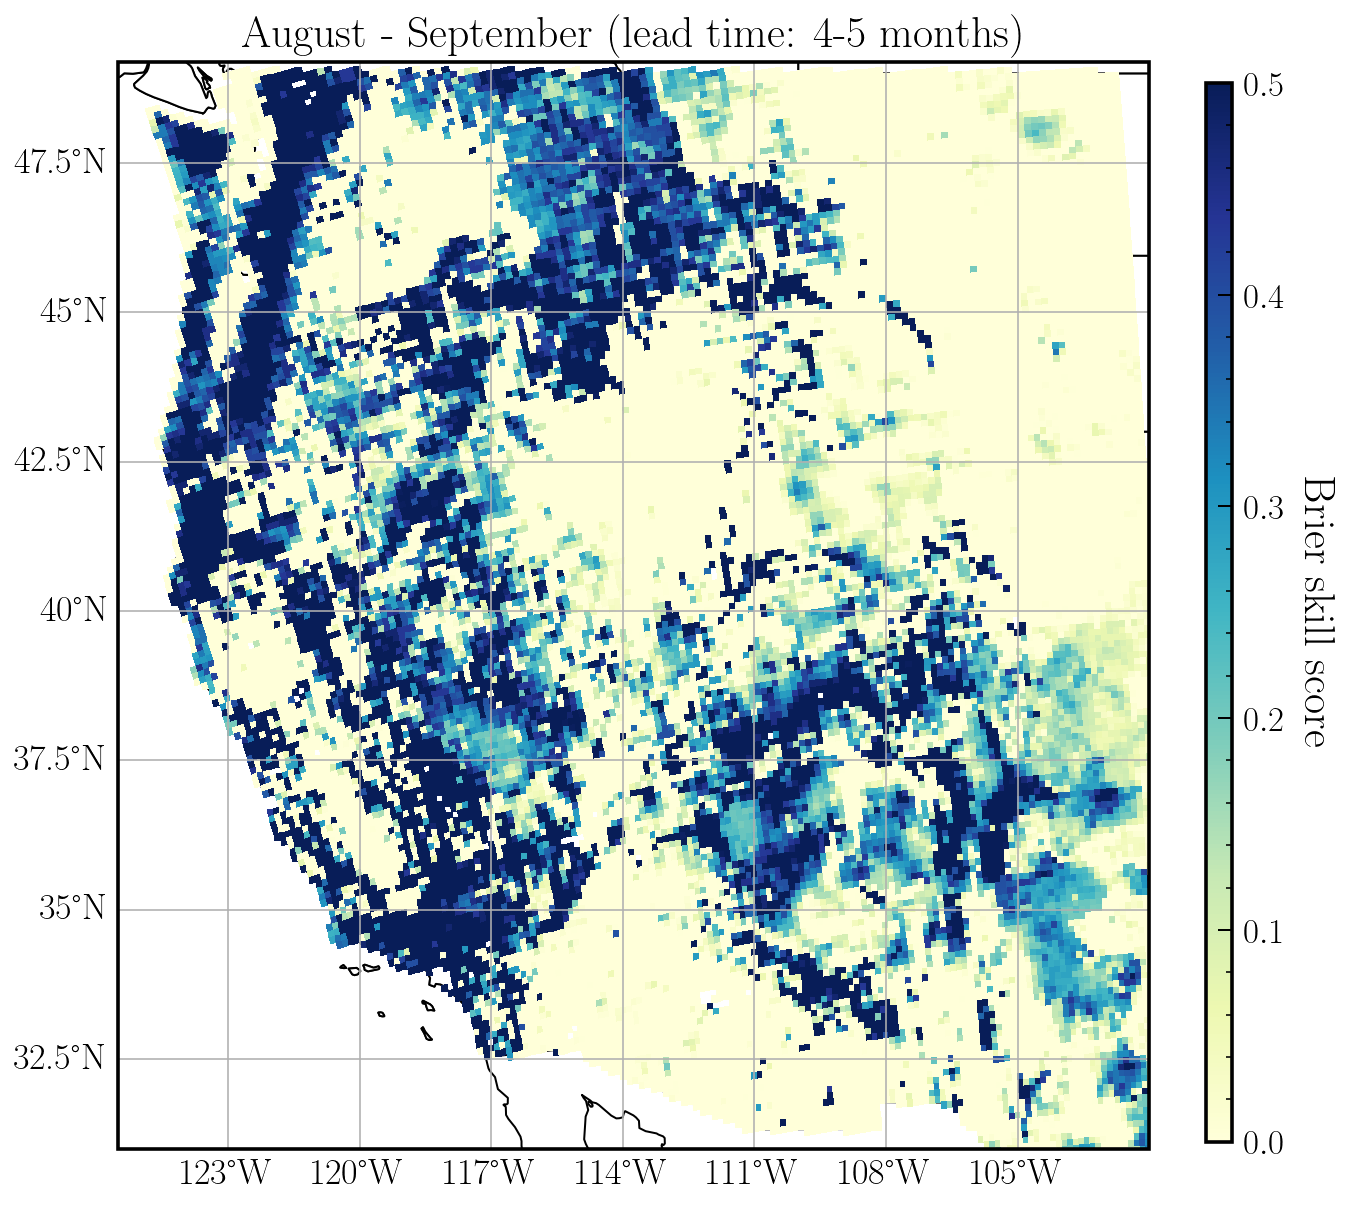

In [ ]:
extent = [-125.5, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor= 'white', zorder= 1);

#ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= 'black', s= 10, transform=ccrs.PlateCarree(), zorder= 10)
aug_sep_bss= bss_xarr.where(bss_xarr > 0, 0).where(maskXY)[3:5].mean(dim= 'time')/bs_baseline_xarr
CS= ax.pcolormesh(loncoord, latcoord, aug_sep_bss/10, cmap=plt.cm.YlGnBu, vmin= 0, vmax= 0.5)
cax= fig.add_axes([ax.get_position().x1 - 0.05, ax.get_position().y1 - 0.75, 0.01, ax.get_position().height - 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'vertical')
cbar.set_label('Brier skill score', labelpad= 25, rotation= 270, fontsize= 22)

ax.tick_params(labeltop=False, top=False, labelright=False, right=True, which='both', labelsize= 30);
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.362/1)
ax.set_title(r'August - September (lead time: 4-5 months)', fontsize= 22);
fig.savefig('../plots/smlfire_output/%s'%firemon_pred_flag + '/bss_%s'%freq_id + '_%d'%seed + '_as.png', bbox_inches='tight', dpi= 200);

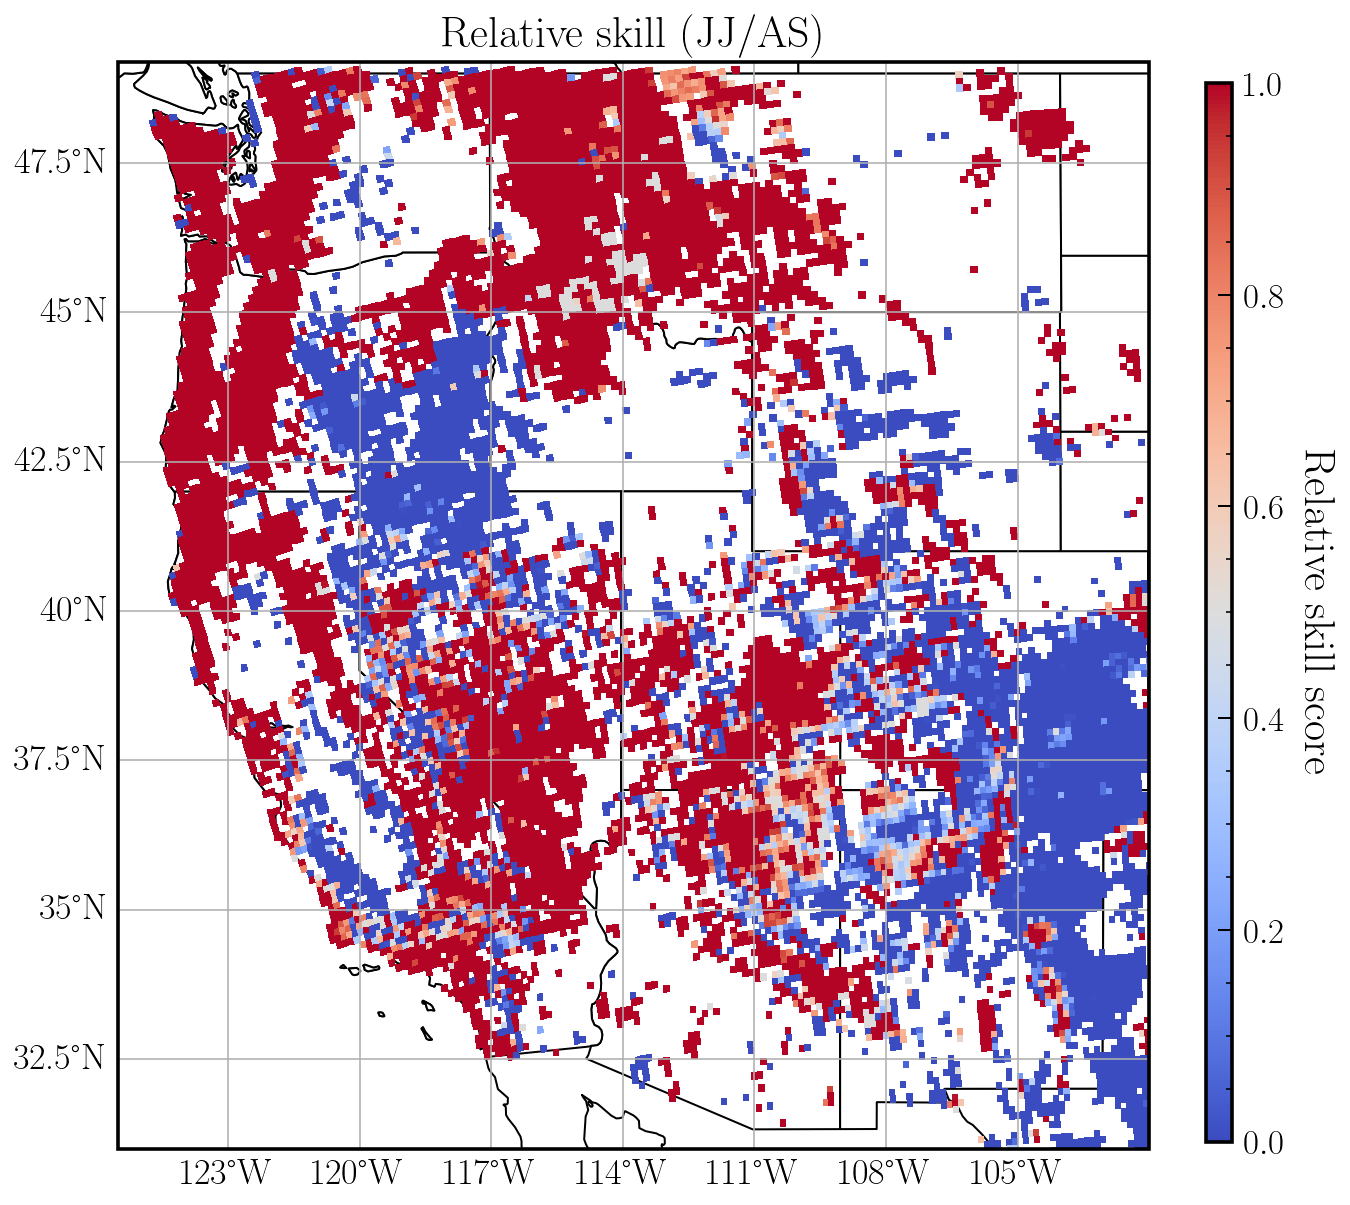

In [ ]:
extent = [-125.5, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor= 'white', zorder= 1);

#ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= 'black', s= 10, transform=ccrs.PlateCarree(), zorder= 10)
#CS= ax.pcolormesh(loncoord, latcoord, (bss_xarr.where(bss_xarr > 0, 0).where(maskXY)[1:3].mean(dim= 'time')/bs_baseline_xarr)/ \
#                                                  (bss_xarr.where(bss_xarr > 0, 0).where(maskXY)[3:5].mean(dim= 'time')/bs_baseline_xarr), cmap=plt.cm.coolwarm, vmin= 0, vmax= 1)
CS= ax.pcolormesh(loncoord, latcoord, jun_jul_bss/aug_sep_bss, cmap=plt.cm.coolwarm, vmin= 0, vmax= 1)
cax= fig.add_axes([ax.get_position().x1 - 0.05, ax.get_position().y1 - 0.75, 0.01, ax.get_position().height - 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'vertical')
cbar.set_label('Relative skill score', labelpad= 25, rotation= 270, fontsize= 22)

ax.tick_params(labeltop=False, top=False, labelright=False, right=True, which='both', labelsize= 30);
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.362/1)
ax.set_title(r'Relative skill (JJ/AS)', fontsize= 22);
#fig.savefig('../plots/smlfire_output/%s'%firemon_pred_flag + '/relative_skill_%s'%freq_id + '_%d'%seed + '.png', bbox_inches='tight', dpi= 200);

## Fire size trends

### Burned area prediction and plotting

In [10]:
sav_freq_flag= False
if sav_freq_flag:
    target_yr= 2022
    firemon_pred_flag= 'dynamical_forecasts'
    ens_no= 35
    freq_id= '08_07_23'
    seed= 654

    pred_mon_arr=  np.array([461, 462, 463]) - (2022 - target_yr)*12

    if firemon_pred_flag == 'observations':
        mdn_freq_test_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag)
        freq_loc_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag)
        X_pred_ur_df= pd.read_hdf('../sav_files/ssf_pred_files/%s_dataframe'%freqlabel + '_%s'%freq_id + '_%d'%seed +  '_obs_%d.h5'%target_yr)
    else:
        mdn_freq_test_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr)
        freq_loc_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr)
        X_pred_ur_df= pd.read_hdf('../sav_files/ssf_pred_files/' + '%s'%firemon_pred_flag + '/pred_fire_freq_dataframe_%s'%freq_id + '_%d'%seed +  '_df_%d'%ens_no + '_%d.h5'%target_yr)

In [11]:
nregions= 18
X_sizes_train, X_sizes_val, y_sizes_train, y_sizes_val, fire_size_train, fire_size_test, X_sizes_test, y_sizes_test= fire_size_data(res= '12km', \
                            dropcols= drop_col_func(mod_type= 'normal', add_var_flag= True, add_var_list= ['SWE_max', 'SWE_mean', 'AvgSWE_3mo', 'Delta_T']), \
                            start_month= 444, tot_test_months= 24, threshold= 4, scaled= True, tflag= True, final_year= 2022) #tflag= True; scaled= True, rh_flag= True
X_sizes_train_df= pd.concat([X_sizes_train, X_sizes_val], sort= False).reset_index().drop(columns=['index'])
X_sizes_tot= pd.concat([X_sizes_train_df, X_sizes_test], sort= False).reset_index().drop(columns=['index'])
fire_size_tot= pd.concat([fire_size_train, fire_size_test], sort= False).reset_index().drop(columns=['index'])

max_fire_train_arr= []
sum_fire_train_arr= []
for r in tqdm(range(nregions)):
    max_fire_train_arr.append(np.max(np.concatenate([fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6 \
                                    for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()])))
    #sum_fire_train_arr.append(np.max([np.sum(fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6) \
    #                                for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()]))
    
max_fire_train_arr= np.asarray(max_fire_train_arr)
sum_fire_train_arr= max_fire_size_sum_func(fire_size_df= fire_size_tot, final_month= 480) #update final month for 2023!

100%|██████████| 18/18 [00:01<00:00, 11.83it/s]


In [12]:
size_id= '08_21_23'
mdn_gpd_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
mdn_gpd_ext_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_ext_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
X_sizes_test_df= X_pred_ur_df.drop(columns= ['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'RH_min3', 'FFWI_max7', 'Avgprec_4mo',  'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', \
                                                                                            'VPD_max7', 'Tmin_max7', 'Elev', 'Delta_T', 'CAPE', 'Southness', 'X', 'Y', 'fire_freq', 'pred_fire_prob'])

KeyError: "['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'RH_min3', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7', 'Elev', 'Delta_T', 'CAPE', 'Southness', 'X', 'Y', 'pred_fire_prob'] not found in axis"

In [19]:
sizelabel= 'gpd'
if sizelabel == 'gpd_ext':
    reg_gpd_ml_pred_size_df= grid_ssf_size_func(mdn_model= mdn_gpd_ext_mod, stat_model= gpd_model, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, pred_mon_flag= True, pred_mons= pred_mon_arr, \
                                        nsamps= 1000, loc_df= freq_loc_df, ml_freq_df= mdn_freq_test_df, X_test_dat= X_sizes_test_df)
elif sizelabel == 'gpd':
    reg_gpd_ml_pred_size_df= grid_ssf_size_func(mdn_model= mdn_gpd_mod, stat_model= gpd_model, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, pred_mon_flag= True, pred_mons= pred_mon_arr, \
                                        nsamps= 1000, loc_df= freq_loc_df, ml_freq_df= mdn_freq_test_df, X_test_dat= X_sizes_test_df)
if firemon_pred_flag == 'observations':
    reg_gpd_ml_pred_size_df.to_hdf('../sav_files/fire_size_pred_dfs/pred_size_df_ml_gpd_%s'%size_id + '_%s'%('_'.join(freqlabel.split('_')[1:])) \
                                                                                                    + '_%s'%sizelabel + '_%s.h5'%target_yr, key= 'df', mode= 'w')
else:
    reg_gpd_ml_pred_size_df.to_hdf('../sav_files/fire_size_pred_dfs/' + '%s'%firemon_pred_flag + '/pred_size_df_ml_gpd_%s'%size_id + '_%s'%('_'.join(freqlabel.split('_')[1:])) \
                                                                                                            + '_%s'%sizelabel + '_%d'%ens_no + '_%s.h5'%target_yr, key= 'df', mode= 'w')

  0%|          | 0/18 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 1/18 [00:00<00:02,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 4/18 [00:00<00:00, 14.56it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 9/18 [00:00<00:00, 25.42it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 12/18 [00:00<00:00, 19.55it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 15/18 [00:00<00:00, 16.06it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 17/18 [00:01<00:00, 14.12it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 18/18 [00:01<00:00, 14.59it/s]


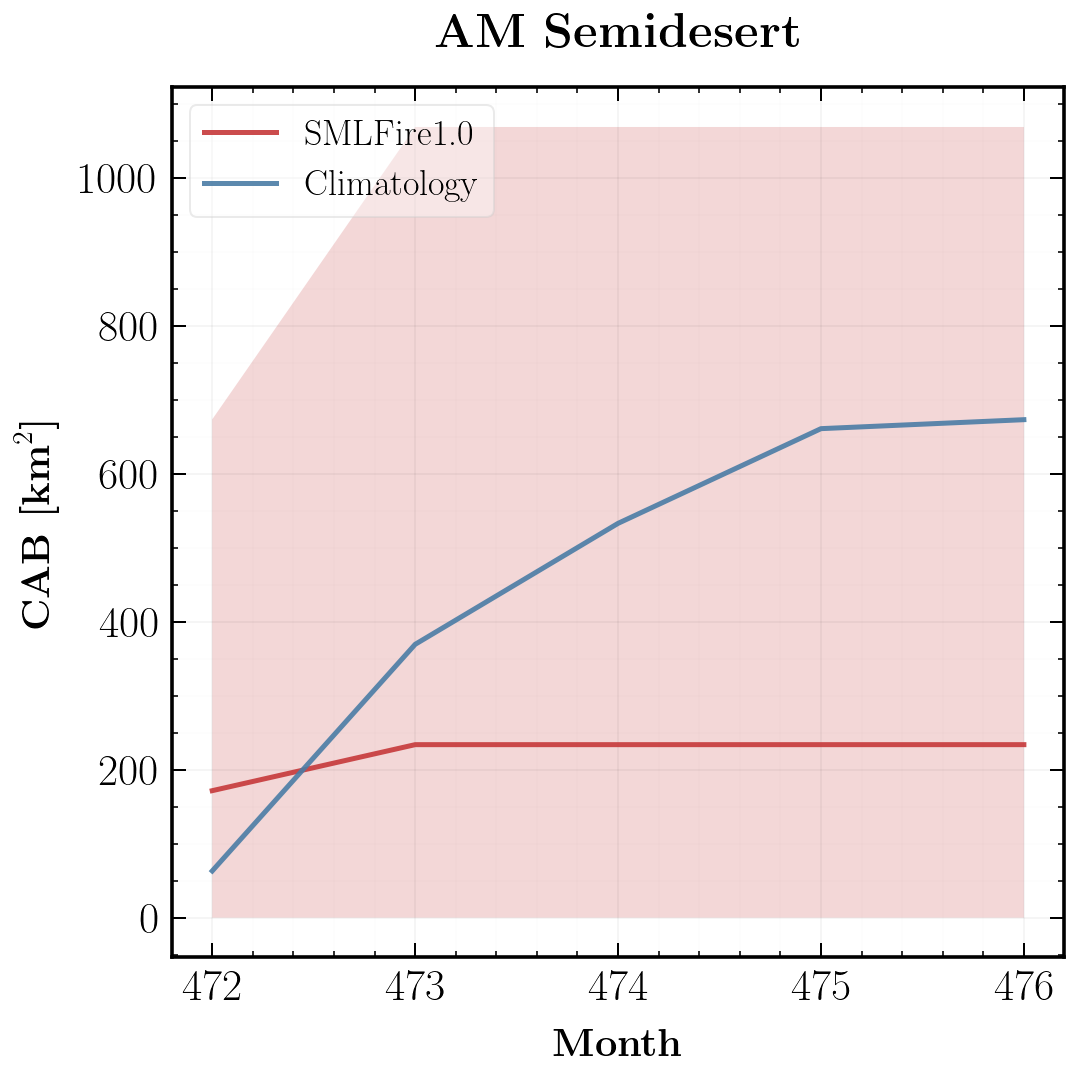

In [26]:
rindx= 10
plt_reg= 'aznmmts'
plot_yr= 2022
fig, ax= plt.subplots(1, 1, figsize=(8, 8))

ax.plot(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['month'], np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['mean_size']), \
                                                                                                                   linewidth= 2.5, label= 'SMLFire1.0')
ax.fill_between(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['month'], np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['high_1sig_size']), \
                                                                               np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['low_1sig_size']), alpha=0.2)
ax.plot(pred_mon_arr, np.cumsum(obs_burned_area_climatology(fire_size_df= fire_size_tot, pred_mons= [5, 6, 7, 8, 9],\
                                                                                                                    regindx= rindx)), linewidth= 2.5, label= 'Climatology')
#ax.plot(pred_mon_arr, np.cumsum(obs_burned_area_ts(fire_size_df= fire_size_tot, pred_mons= pred_mon_arr, regindx= rindx)), \
#                                                                                                                    linestyle= '--', color= 'black', linewidth= 3, label= 'Observations')

ax.set_ylabel(r'{\bf CAB [${\bf km}^2$]}', fontsize= 20, labelpad= 10);
ax.set_xlabel(r'{\bf Month}', fontsize= 20, labelpad= 10);
#ax.set_ylim(-100, 3000)

ax.set_title(r'{\bf %s}'%reg_name[rindx], fontsize= 24, pad= 20);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.legend(loc= 'upper left', frameon= True, fontsize= 18);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/smlfire_output/dynamical_forecasts/pred_fire_size_%s'%size_id + '_%d_'%plot_yr + 'obs_%s.png'%plt_reg, bbox_inches='tight', dpi= 200);

### Ensemble burned area plots

In [19]:
sizelabel= 'gpd'
freqlabel= 'pred_high_2sig'
size_id= '08_21_23'
ens_no_arr= np.arange(0, 51, 1)

In [20]:
reg_gpd_ml_pred_size_df= pd.DataFrame([])
for enp in tqdm(ens_no_arr):
    tmp_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/' + '%s'%firemon_pred_flag + '/pred_size_df_ml_gpd_%s'%size_id + '_%s'%('_'.join(freqlabel.split('_')[1:])) \
                                                                                                            + '_%s'%sizelabel + '_%d'%enp + '_%s.h5'%target_yr)
    reg_gpd_ml_pred_size_df= pd.concat([reg_gpd_ml_pred_size_df, tmp_df], axis= 0)
    # include ensemble member number in dataframe

100%|██████████| 51/51 [00:00<00:00, 212.51it/s]


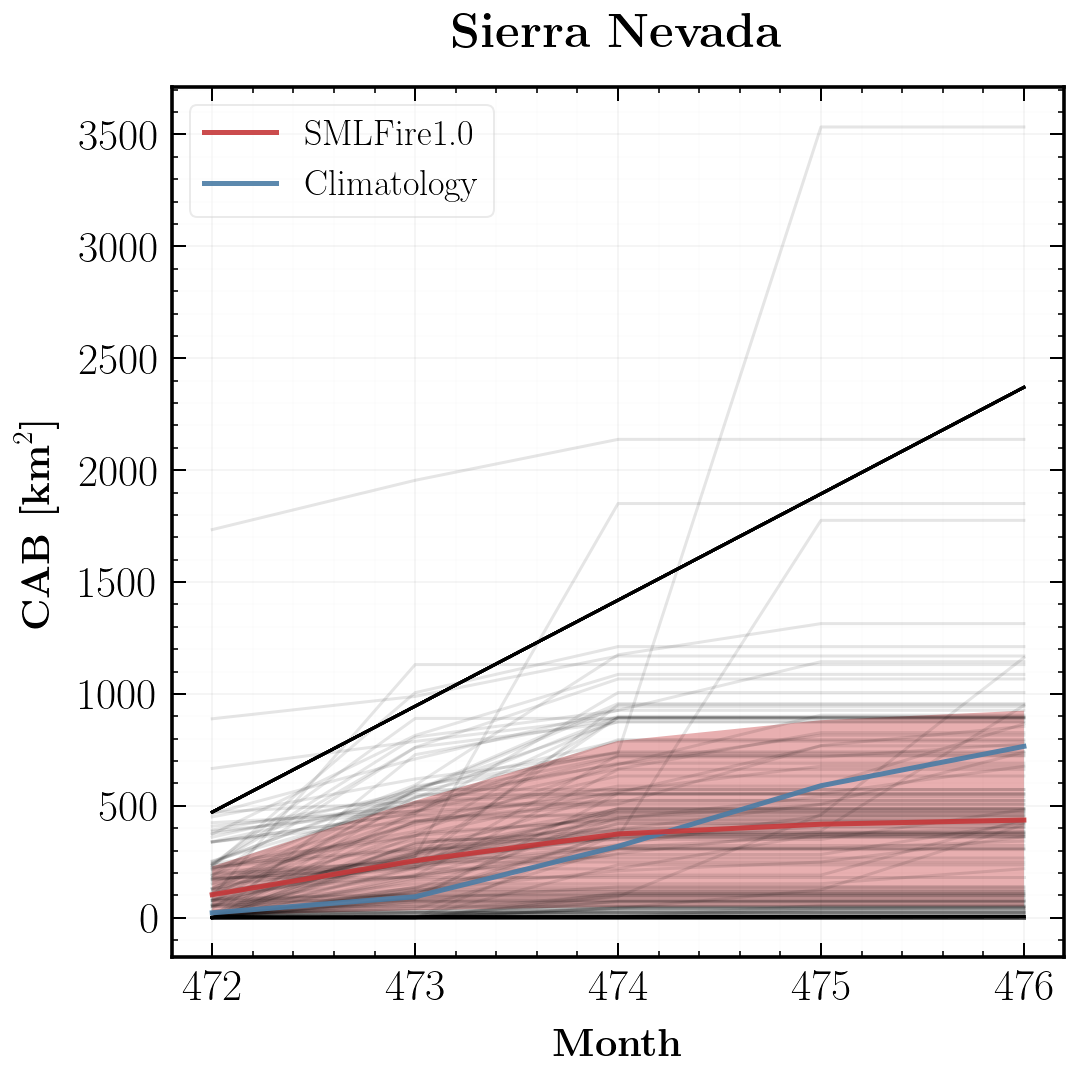

In [38]:
rindx= 1
plt_reg= 'sierra'
plot_yr= 2023
fig, ax= plt.subplots(1, 1, figsize=(8, 8))

ax.plot(pred_mon_arr, np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx).groupby('month').mean()['mean_size']), \
                                                                                                                   linewidth= 2.5, label= 'SMLFire1.0', zorder= 10)
ax.fill_between(pred_mon_arr, np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx).groupby('month').mean()['high_1sig_size']), \
                                                        np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx).groupby('month').mean()['low_1sig_size']), alpha=0.4)
for enp in ens_no_arr:
    tmp_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/' + '%s'%firemon_pred_flag + '/pred_size_df_ml_gpd_%s'%size_id + '_%s'%('_'.join(freqlabel.split('_')[1:])) \
                                                                                                            + '_%s'%sizelabel + '_%d'%enp + '_%s.h5'%target_yr)
    plt.plot(pred_mon_arr, np.cumsum(tmp_df.groupby('reg_indx').get_group(rindx)), c= 'black', alpha= 0.1, linewidth= 1.5, zorder= 1)
ax.plot(pred_mon_arr, np.cumsum(obs_burned_area_climatology(fire_size_df= fire_size_tot, pred_mons= [5, 6, 7, 8, 9], regindx= rindx)), linewidth= 2.5, label= 'Climatology', zorder= 5)
#ax.plot(pred_mon_arr, np.cumsum(obs_burned_area_ts(fire_size_df= fire_size_tot, pred_mons= pred_mon_arr, regindx= rindx)), \
#                                                                                                                    linestyle= '--', color= 'black', linewidth= 3, label= 'Observations')

ax.set_ylabel(r'{\bf CAB [${\bf km}^2$]}', fontsize= 20, labelpad= 10);
ax.set_xlabel(r'{\bf Month}', fontsize= 20, labelpad= 10);
#ax.set_ylim(-100, 3000)

ax.set_title(r'{\bf %s}'%reg_name[rindx], fontsize= 24, pad= 20);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.legend(loc= 'upper left', frameon= True, fontsize= 18);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
plt.savefig('../plots/smlfire_output/dynamical_forecasts/pred_fire_size_%s'%size_id + '_%d'%plot_yr + '_%s'%('_'.join(freqlabel.split('_')[1:])) \
                                                                                    + '_%s'%sizelabel + '_mean_BA_spread_%s.pdf'%plt_reg, bbox_inches='tight', dpi= 200);

In [4]:
# size_id= '08_21_23'
# target_yr= 2022
# pred_mon_arr= np.array([461, 462, 463, 464, 465])
# reg_gpd_ml_pred_size_df= pd.read_hdf('../sav_files/ssf_pred_files/pred_size_df_ml_gpd_%s'%size_id + '_mean_freq_%s.h5'%target_yr)
# reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW Mts.", 6: "Columbia Plateau", 7:"Northern Rockies", \
#           8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
#           15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
# pred_mon_arr= np.insert(pred_mon_arr, 0, [457, 458, 459, 460])